In [2]:
import numpy as np
from tqdm import tnrange
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,"../")
import data_generator as gen
import TensorNetwork as tn

from torch.utils.data import DataLoader, Dataset, TensorDataset, SubsetRandomSampler

In [3]:
class NumpyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], self.label[index])

In [4]:
def prepare_dataset(data, label, train_perc, val_perc, train_batch_size, val_batch_size, test_batch_size):
    
    def psi(x):
        x = np.array((np.sin(np.pi*x/2),np.cos(np.pi*x/2)))
        return np.transpose(x, [1,2,0])


    # flatten images
    x = data.reshape(len(data),-1)
    # embedd them
    x = psi(x)
    
    # training/test splitting
    m = int(len(x)*train_perc)
    x_train= x[:m]
    y_train = label[:m]
    x_test =  x[m:]
    y_test = label[m:]
    
    # define custom NumpyDatasets
    train_set = NumpyDataset(x_train, y_train)
    test_set =  NumpyDataset(x_test, y_test)
   
    train_len = int(m*(1-val_perc))
    train_sampler = SubsetRandomSampler(np.arange(train_len))
    val_sampler = SubsetRandomSampler(np.arange(train_len,m))

    train_loader = DataLoader(train_set, train_batch_size, sampler=train_sampler, drop_last=True, collate_fn=lambda x: x)
    val_loader = DataLoader(train_set, val_batch_size, sampler=val_sampler, drop_last=False, collate_fn=lambda x: x)
    test_loader = DataLoader(test_set, test_batch_size, drop_last=False, collate_fn=lambda x: x)

    return train_loader, val_loader, test_loader

In [9]:
n_samples = 1000
linear_dim = 5
M = 20

In [10]:
(data, label) = gen.create_dataset(n_samples, sigma=0.7)
batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)

In [13]:
net = tn.Network(N=linear_dim**2, M=M, L=2)

In [15]:
train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)

Epoch 0 - train accuracy : 0.9891 - val accuracy: 0.9875



# Time profiling

In [26]:
import time

## Scaling in the number of samples

In [25]:
n_samples = [1000*i**2 for i in range(1,9)]
print("Number of samples tried: \n", n_samples)

# keep them fixed
linear_dim = 5
M = 20

Number of samples tried: 
 [1000, 4000, 9000, 16000, 25000, 36000, 49000, 64000]


In [31]:
times_n_samples = []
for n in n_samples:
    print("Testing with %d samples..."%n)
    (data, label) = gen.create_dataset(n, sigma=0.7)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_n_samples.append(dt)

Testing with 1000 samples...


Epoch 0 - train accuracy : 0.9828 - val accuracy: 0.9812

Time for 1 epoch: 5.59 s 

Testing with 4000 samples...


Epoch 0 - train accuracy : 0.9871 - val accuracy: 0.9844

Time for 1 epoch: 20.63 s 

Testing with 9000 samples...


Epoch 0 - train accuracy : 0.9911 - val accuracy: 0.9854 

Time for 1 epoch: 49.90 s 

Testing with 16000 samples...


Epoch 0 - train accuracy : 0.9888 - val accuracy: 0.9844 

Time for 1 epoch: 86.18 s 

Testing with 25000 samples...


Epoch 0 - train accuracy : 0.9913 - val accuracy: 0.9810 

Time for 1 epoch: 134.82 s 

Testing with 36000 samples...


Epoch 0 - train accuracy : 0.9892 - val accuracy: 0.9877 

Time for 1 epoch: 190.00 s 

Testing with 49000 samples...


Epoch 0 - train accuracy : 0.9896 - val accuracy: 0.9829 

Time for 1 epoch: 262.37 s 

Testing with 64000 samples...


Epoch 0 - train accuracy : 0.9891 - val accuracy: 0.9848 

Time for 1 epoch: 336.11 s 



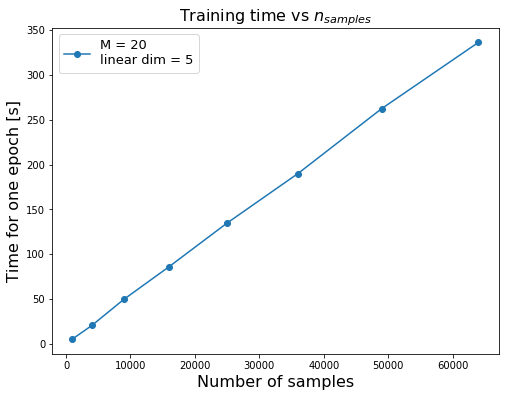

In [33]:
plt.figure(figsize=(8,6))
plt.plot(n_samples, times_n_samples, '-o', label='M = %d \nlinear dim = %d'%(M,linear_dim))
plt.xlabel("Number of samples", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title(r"Training time vs $n_{samples}$", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Scaling in the number of pixels

In [34]:
linear_dims = np.arange(4,29,4)
print("Linear dimensions tested: \n", linear_dims)

# keep them fixed
n_samples = 1000
M = 20

Linear dimensions tested: 
 [ 4  8 12 16 20 24 28]


In [37]:
times_linear_dims = []
for linear_dim in linear_dims:
    print("Testing with %d x %d images..."%(linear_dim,linear_dim))
    (data, label) = gen.create_dataset(n_samples, sigma=0.7, linear_dim = linear_dim)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_linear_dims.append(dt)

Testing with 4 x 4 images...


Epoch 0 - train accuracy : 0.9922 - val accuracy: 0.9812

Time for 1 epoch: 3.42 s 

Testing with 8 x 8 images...


Epoch 0 - train accuracy : 0.5578 - val accuracy: 0.5625

Time for 1 epoch: 13.65 s 

Testing with 12 x 12 images...


Epoch 0 - train accuracy : 0.9359 - val accuracy: 0.9250 

Time for 1 epoch: 31.80 s 

Testing with 16 x 16 images...


Epoch 0 - train accuracy : 0.4766 - val accuracy: 0.5188 

Time for 1 epoch: 58.87 s 

Testing with 20 x 20 images...


Epoch 0 - train accuracy : 0.5266 - val accuracy: 0.4813 

Time for 1 epoch: 95.17 s 

Testing with 24 x 24 images...


Epoch 0 - train accuracy : 0.4844 - val accuracy: 0.4875 

Time for 1 epoch: 127.21 s 

Testing with 28 x 28 images...


Epoch 0 - train accuracy : 0.5078 - val accuracy: 0.5375 

Time for 1 epoch: 172.25 s 



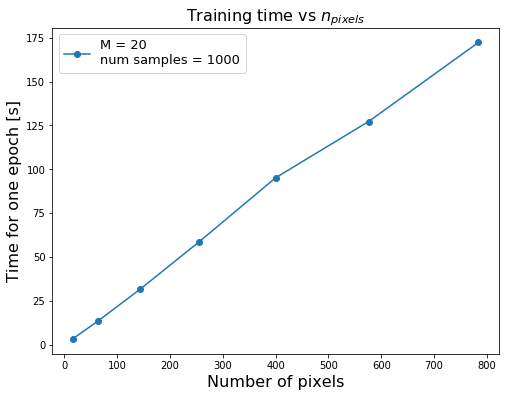

In [42]:
plt.figure(figsize=(8,6))
plt.plot(linear_dims**2, times_linear_dims, '-o', label='M = %d \nnum samples = %d'%(M,n_samples))
plt.xlabel("Number of pixels", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title(r"Training time vs $n_{pixels}$", fontsize=16)
plt.legend(fontsize=13)
plt.show()

## Scaling in the bond dimension

In [43]:
Ms = [10*i for i in range(1,11)]
print("Bond dimensions tested: \n", Ms)

# keep them fixed
n_samples = 1000
linear_dim = 5

Bond dimensions tested: 
 [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [45]:
times_bond_dims = []
for M in Ms:
    print("Testing with bond dimension %d..."%M)
    (data, label) = gen.create_dataset(n_samples, sigma=0.7)
    batch_size = {'train_batch_size':16, 'val_batch_size':128, 'test_batch_size':128}
    train_loader, val_loader, test_loader = prepare_dataset(data, label, 0.8, 0.2, **batch_size)
    
    # independent from the number of samples
    net = tn.Network(N=linear_dim**2, M=M, L=2)
    
    start = time.time()
    train_acc, val_acc = net.train(train_loader, val_loader, lr = 0.5, n_epochs = 1, print_freq=1)
    dt = time.time() - start
    print("Time for 1 epoch: %.2f s \n"%dt)
    times_bond_dims.append(dt)

Testing with bond dimension 10...


Epoch 0 - train accuracy : 0.9906 - val accuracy: 0.9750

Time for 1 epoch: 5.52 s 

Testing with bond dimension 20...


Epoch 0 - train accuracy : 0.9859 - val accuracy: 0.9750

Time for 1 epoch: 5.96 s 

Testing with bond dimension 30...


Epoch 0 - train accuracy : 0.9828 - val accuracy: 0.9688

Time for 1 epoch: 5.82 s 

Testing with bond dimension 40...


Epoch 0 - train accuracy : 0.9797 - val accuracy: 0.9938

Time for 1 epoch: 5.90 s 

Testing with bond dimension 50...


Epoch 0 - train accuracy : 0.9922 - val accuracy: 0.9750

Time for 1 epoch: 6.26 s 

Testing with bond dimension 60...


Epoch 0 - train accuracy : 0.9766 - val accuracy: 0.9812

Time for 1 epoch: 7.23 s 

Testing with bond dimension 70...


Epoch 0 - train accuracy : 0.9812 - val accuracy: 0.9750

Time for 1 epoch: 7.84 s 

Testing with bond dimension 80...


Epoch 0 - train accuracy : 0.9859 - val accuracy: 0.9875

Time for 1 epoch: 9.77 s 

Testing with bond dimension 90...


Epoch 0 - train accuracy : 0.9938 - val accuracy: 0.9938

Time for 1 epoch: 11.14 s 

Testing with bond dimension 100...


Epoch 0 - train accuracy : 0.9812 - val accuracy: 0.9812

Time for 1 epoch: 13.97 s 



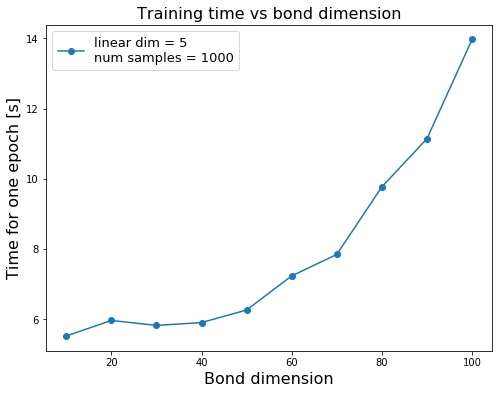

In [47]:
plt.figure(figsize=(8,6))
plt.plot(Ms, times_bond_dims, '-o', label='linear dim = %d \nnum samples = %d'%(linear_dim,n_samples))
plt.xlabel("Bond dimension", fontsize=16)
plt.ylabel("Time for one epoch [s]", fontsize=16)
plt.title("Training time vs bond dimension", fontsize=16)
plt.legend(fontsize=13)
plt.show()